In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ace_tools_open as tools; 
import matplotx as pltx
import numpy as np

In [21]:
def load_and_merge_all_datasets(base_path, folder_configs):
    """
    Carica e merge tutti i dataset di weak scaling da multiple cartelle,
    poi li separa per dimensione del messaggio.
    
    Parameters:
    -----------
    base_path : str
        Percorso base del progetto
    folder_configs : list of dict
        Lista di configurazioni per ogni cartella, formato:
        [{'folder': 'csv/weak', 'message_size': 1024},
         {'folder': 'csv2', 'message_size': 10240},
         {'folder': 'csv3', 'message_size': 921600}]
        
    Returns:
    --------
    dict
        Dizionario con chiavi come message_size e valori come DataFrame
        {1024: df_1024, 10240: df_10240, 921600: df_921600}
    """
    
    # Mappa degli algoritmi
    algorithm_map = {
        '1': 'basic_linear',
        '2': 'chain',
        '3': 'pipeline',
        '4': 'pipeline_non_blocking',
        '6': 'binomial'
    }
    
    all_datasets = []
    
    # Carica dati da ogni cartella
    for config in folder_configs:
        folder_path = os.path.join(base_path, config['folder'])
        message_size = config['message_size']
        
        print(f"\n=== Caricando da {folder_path} (message_size: {message_size}) ===")
        
        if not os.path.exists(folder_path):
            print(f"ATTENZIONE: Cartella {folder_path} non trovata!")
            continue
        
        # Lista dei file CSV di weak scaling
        files = sorted([f for f in os.listdir(folder_path) if f.endswith(".csv") and "_weak_P" in f])
        
        if not files:
            print(f"Nessun file CSV di weak scaling trovato in {folder_path}")
            continue
        
        print(f"Trovati {len(files)} file CSV")
        
        # Carica e combina i file di questa cartella
        combined_data = []
        
        for file in files:
            try:
                # Estrai informazioni dal nome del file
                algo_id, _, proc_str = file.replace(".csv", "").split("_")
                proc_count = int(proc_str[1:])
                algo_name = algorithm_map.get(algo_id, f"unknown_{algo_id}")
                
                # Carica il CSV
                df = pd.read_csv(os.path.join(folder_path, file))
                df["algorithm"] = algo_name
                df["processes"] = proc_count
                df["message_size"] = message_size  # Aggiungi la dimensione del messaggio
                combined_data.append(df)
                
                print(f"  - {file}: {algo_name}, {proc_count} processi, {len(df)} righe")
                
            except Exception as e:
                print(f"  - ERRORE nel caricare {file}: {e}")
                continue
        
        if combined_data:
            # Combina tutti i file di questa cartella
            folder_df = pd.concat(combined_data, ignore_index=True)
            all_datasets.append(folder_df)
            print(f"Dataset cartella combinato: {len(folder_df)} righe")
    
    if not all_datasets:
        raise ValueError("Nessun dato valido è stato caricato da nessuna cartella")
    
    # Combina tutti i dataset
    print(f"\n=== Combinando tutti i dataset ===")
    df_all = pd.concat(all_datasets, ignore_index=True)
    
    # Ordina tutto per message_size, algorithm, processes, count
    df_all = df_all.sort_values(by=["message_size", "algorithm", "processes", "count"])
    
    print(f"Dataset totale combinato: {len(df_all)} righe")
    print(f"Message sizes presenti: {sorted(df_all['message_size'].unique())}")
    print(f"Algoritmi: {sorted(df_all['algorithm'].unique())}")
    
    # Separa per dimensione del messaggio
    datasets_by_size = {}
    
    for message_size in sorted(df_all['message_size'].unique()):
        df_size = df_all[df_all['message_size'] == message_size].copy()
        df_size = df_size.sort_values(by=["algorithm", "processes", "count"])
        datasets_by_size[message_size] = df_size
        
        print(f"\nDataset message_size {message_size}: {len(df_size)} righe")
        print(f"  - Algoritmi: {sorted(df_size['algorithm'].unique())}")
        print(f"  - Processi: {sorted(df_size['processes'].unique())}")
    
    return datasets_by_size

def get_size_label(message_size):
    """
    Converte la dimensione del messaggio in una etichetta leggibile
    """
    if message_size >= 1000000:
        return f"{message_size // 1000000}mb"
    elif message_size >= 1000:
        return f"{message_size // 1000}kb"
    else:
        return f"{message_size}b"

# Esempio di utilizzo:
if __name__ == "__main__":
    # Configurazione delle cartelle e dimensioni
    base_path = '/home/robertalamberti/HPC-project/ex2/ex_a/bcast'
    
    folder_configs = [
        {'folder': 'csv/weak', 'message_size': 1024},
        {'folder': 'csv2', 'message_size': 10240}, 
        {'folder': 'csv3', 'message_size': 921600}
    ]
    
    # Carica tutti i dataset
    datasets = load_and_merge_all_datasets(base_path, folder_configs)
    
    # Accedi ai singoli dataset
    df_1kb = datasets[1024]        # Dataset per 1kb
    df_10kb = datasets[10240]      # Dataset per 10kb  
    df_1mb = datasets[921600]      # Dataset per ~1mb
    
    print(f"\n=== Riepilogo finale ===")
    for message_size, df in datasets.items():
        size_label = get_size_label(message_size)
        print(f"Dataset {size_label} ({message_size}): {len(df)} righe")
    
    # Esempio di come usare i dataset nei grafici
    print(f"\nPer usare nei grafici:")
    print(f"df_1kb = datasets[1024]")
    print(f"df_10kb = datasets[10240]") 
    print(f"df_1mb = datasets[921600]")


=== Caricando da /home/robertalamberti/HPC-project/ex2/ex_a/bcast/csv/weak (message_size: 1024) ===
Trovati 45 file CSV
  - 1_weak_P1.csv: basic_linear, 1 processi, 1 righe
  - 1_weak_P128.csv: basic_linear, 128 processi, 1 righe
  - 1_weak_P16.csv: basic_linear, 16 processi, 1 righe
  - 1_weak_P2.csv: basic_linear, 2 processi, 1 righe
  - 1_weak_P256.csv: basic_linear, 256 processi, 1 righe
  - 1_weak_P32.csv: basic_linear, 32 processi, 1 righe
  - 1_weak_P4.csv: basic_linear, 4 processi, 1 righe
  - 1_weak_P64.csv: basic_linear, 64 processi, 1 righe
  - 1_weak_P8.csv: basic_linear, 8 processi, 1 righe
  - 2_weak_P1.csv: chain, 1 processi, 1 righe
  - 2_weak_P128.csv: chain, 128 processi, 1 righe
  - 2_weak_P16.csv: chain, 16 processi, 1 righe
  - 2_weak_P2.csv: chain, 2 processi, 1 righe
  - 2_weak_P256.csv: chain, 256 processi, 1 righe
  - 2_weak_P32.csv: chain, 32 processi, 1 righe
  - 2_weak_P4.csv: chain, 4 processi, 1 righe
  - 2_weak_P64.csv: chain, 64 processi, 1 righe
  - 2_

In [26]:
def create_timing_plot(df_data, message_size_bytes, title_suffix=""):
    """
    Crea un grafico dei timing per una specifica dimensione dei dati
    
    Parameters:
    -----------
    df_data : pd.DataFrame
        DataFrame con i dati contenente colonne: algorithm, processes, time
    message_size_bytes : int
        Dimensione del messaggio in bytes (es: 1024, 10240, 921600)
    title_suffix : str
        Suffisso opzionale per il titolo
        
    Returns:
    --------
    dict
        Dizionario con i risultati medi per ogni algoritmo
    """
    
    # Crea un dizionario per memorizzare i risultati medi per ogni algoritmo
    all_results = {}
    
    # Calcola i timing medi per ogni algoritmo raggruppando per numero di processi
    for algorithm in df_data['algorithm'].unique():
        algo_data = df_data[df_data['algorithm'] == algorithm].copy()
        
        # Calcola la media dei tempi per ogni numero di processi
        mean_results = algo_data.groupby('processes')['time'].mean().reset_index()
        mean_results.columns = ['NP', 'Time']  # Rinomina per compatibilità
        
        # Memorizza i risultati nel dizionario
        all_results[algorithm] = mean_results
    
    # Plotting
    plt.figure(figsize=(12, 7))
    
    # Colori aggiornati per ogni algoritmo
    algorithm_colors = {
        'basic_linear': '#FF6B6B',
        'binomial': '#4ECDC4', 
        'chain': '#45B7D1',
        'pipeline': '#96CEB4',
        'pipeline_non_blocking': '#E4BC1C'  # Colore aggiornato
    }
    
    # Loop attraverso il dizionario per plottare ogni set di risultati
    for plot_name, mean_results in all_results.items():
        color = algorithm_colors.get(plot_name, None)
        plt.plot(mean_results['NP'], mean_results['Time'], 
                 marker='o', 
                 linestyle='--', 
                 label=plot_name,
                 linewidth=2,
                 markersize=6,
                 color=color)
    
    # Usa matplotx per le etichette delle linee a destra
    pltx.line_labels()
    
    # Determina la stringa della dimensione per il titolo (converti da bytes)
    if message_size_bytes >= 1000000:
        size_string = f"{message_size_bytes // 1000000}mb"
    elif message_size_bytes >= 1000:
        size_string = f"{message_size_bytes // 1000}kb"
    else:
        size_string = f"{message_size_bytes}b"
    
    # Configurazione del grafico
    plt.title(f'Mean Timing vs #Processes - Data size shared per process: {size_string}{title_suffix}')
    plt.xlabel('Number of total Processes')
    plt.ylabel('Mean Timing (seconds)')
    plt.grid(True, alpha=0.3)
    
    # Usa scala lineare e imposta il limite inferiore a 0
    plt.ylim(bottom=0)
    
    # Formatter per mostrare i valori reali invece della notazione scientifica
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(formatter)
    
    # Layout ottimizzato
    plt.tight_layout()
    
    # Mostra il grafico
    plt.show()
    
    # Stampa informazioni sui dati
    print(f"\nInformazioni sui dati {size_string}:")
    for algo, data in all_results.items():
        print(f"- {algo}: {len(data)} punti dati")
        print(f"  Processi: {data['NP'].min()}-{data['NP'].max()}")
        print(f"  Tempi: {data['Time'].min():.6f}-{data['Time'].max():.6f} secondi")
    
    return all_results

def create_all_timing_plots(datasets):
    """
    Crea grafici per tutti i dataset caricati
    
    Parameters:
    -----------
    datasets : dict
        Dizionario restituito da load_and_merge_all_datasets()
        Formato: {message_size: dataframe}
        
    Returns:
    --------
    dict
        Dizionario con i risultati per ogni dimensione
    """
    
    all_plot_results = {}
    
    # Ordina per dimensione del messaggio per una visualizzazione logica
    for message_size in sorted(datasets.keys()):
        df = datasets[message_size]
        
        # Determina l'etichetta per il print
        if message_size >= 1000000:
            size_label = f"{message_size // 1000000}mb"
        elif message_size >= 1000:
            size_label = f"{message_size // 1000}kb"
        else:
            size_label = f"{message_size}b"
        
        print(f"\n{'='*60}")
        print(f"=== Creando grafico per {size_label} ({message_size} bytes) ===")
        print(f"{'='*60}")
        
        # Crea il grafico
        results = create_timing_plot(df, message_size)
        all_plot_results[message_size] = results
        
        print(f"\nGrafico per {size_label} completato!")
    
    return all_plot_results

# Esempio di utilizzo completo:
if __name__ == "__main__":
    # Supponiamo di aver già caricato i datasets con la funzione precedente
    # datasets = load_and_merge_all_datasets(base_path, folder_configs)
    
    # Crea tutti i grafici
    # plot_results = create_all_timing_plots(datasets)
    
    # Oppure crea singoli grafici:
    # Per 1kb
    # results_1kb = create_timing_plot(datasets[1024], 1024)
    
    # Per 10kb  
    # results_10kb = create_timing_plot(datasets[10240], 10240)
    
    # Per ~1mb
    # results_1mb = create_timing_plot(datasets[921600], 921600)
    
    print("Funzioni per la creazione dei grafici definite!")
    print("\nPer utilizzare:")
    print("1. Carica i datasets: datasets = load_and_merge_all_datasets(...)")
    print("2. Crea tutti i grafici: plot_results = create_all_timing_plots(datasets)")
    print("3. Oppure crea singoli grafici: create_timing_plot(datasets[1024], 1024)")

# Funzione di convenienza per creare un singolo grafico da un message_size specifico
def plot_single_message_size(datasets, message_size):
    """
    Crea un grafico per una specifica dimensione di messaggio
    
    Parameters:
    -----------
    datasets : dict
        Dizionario dei datasets
    message_size : int
        Dimensione del messaggio da plottare (es: 1024, 10240, 921600)
    """
    if message_size not in datasets:
        available_sizes = list(datasets.keys())
        print(f"Dimensione {message_size} non trovata!")
        print(f"Dimensioni disponibili: {available_sizes}")
        return None
    
    return create_timing_plot(datasets[message_size], message_size)

Funzioni per la creazione dei grafici definite!

Per utilizzare:
1. Carica i datasets: datasets = load_and_merge_all_datasets(...)
2. Crea tutti i grafici: plot_results = create_all_timing_plots(datasets)
3. Oppure crea singoli grafici: create_timing_plot(datasets[1024], 1024)



=== Caricando da /home/robertalamberti/HPC-project/ex2/ex_a/bcast/csv/weak (message_size: 1024) ===
Trovati 45 file CSV
  - 1_weak_P1.csv: basic_linear, 1 processi, 1 righe
  - 1_weak_P128.csv: basic_linear, 128 processi, 1 righe
  - 1_weak_P16.csv: basic_linear, 16 processi, 1 righe
  - 1_weak_P2.csv: basic_linear, 2 processi, 1 righe
  - 1_weak_P256.csv: basic_linear, 256 processi, 1 righe
  - 1_weak_P32.csv: basic_linear, 32 processi, 1 righe
  - 1_weak_P4.csv: basic_linear, 4 processi, 1 righe
  - 1_weak_P64.csv: basic_linear, 64 processi, 1 righe
  - 1_weak_P8.csv: basic_linear, 8 processi, 1 righe
  - 2_weak_P1.csv: chain, 1 processi, 1 righe
  - 2_weak_P128.csv: chain, 128 processi, 1 righe
  - 2_weak_P16.csv: chain, 16 processi, 1 righe
  - 2_weak_P2.csv: chain, 2 processi, 1 righe
  - 2_weak_P256.csv: chain, 256 processi, 1 righe
  - 2_weak_P32.csv: chain, 32 processi, 1 righe
  - 2_weak_P4.csv: chain, 4 processi, 1 righe
  - 2_weak_P64.csv: chain, 64 processi, 1 righe
  - 2_

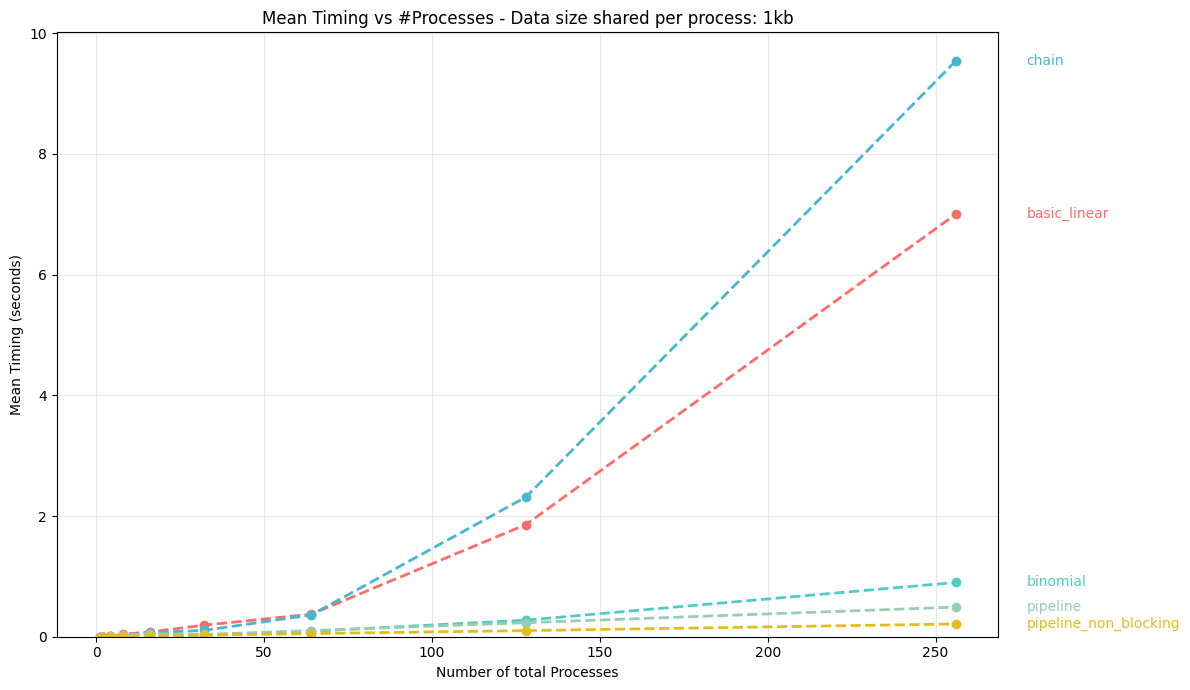


Informazioni sui dati 1kb:
- basic_linear: 9 punti dati
  Processi: 1-256
  Tempi: 0.000000-6.998940 secondi
- binomial: 9 punti dati
  Processi: 1-256
  Tempi: 0.000000-0.898921 secondi
- chain: 9 punti dati
  Processi: 1-256
  Tempi: 0.000000-9.537000 secondi
- pipeline: 9 punti dati
  Processi: 1-256
  Tempi: 0.000010-0.490831 secondi
- pipeline_non_blocking: 9 punti dati
  Processi: 1-256
  Tempi: 0.000006-0.211424 secondi

Grafico per 1kb completato!

=== Creando grafico per 10kb (10240 bytes) ===


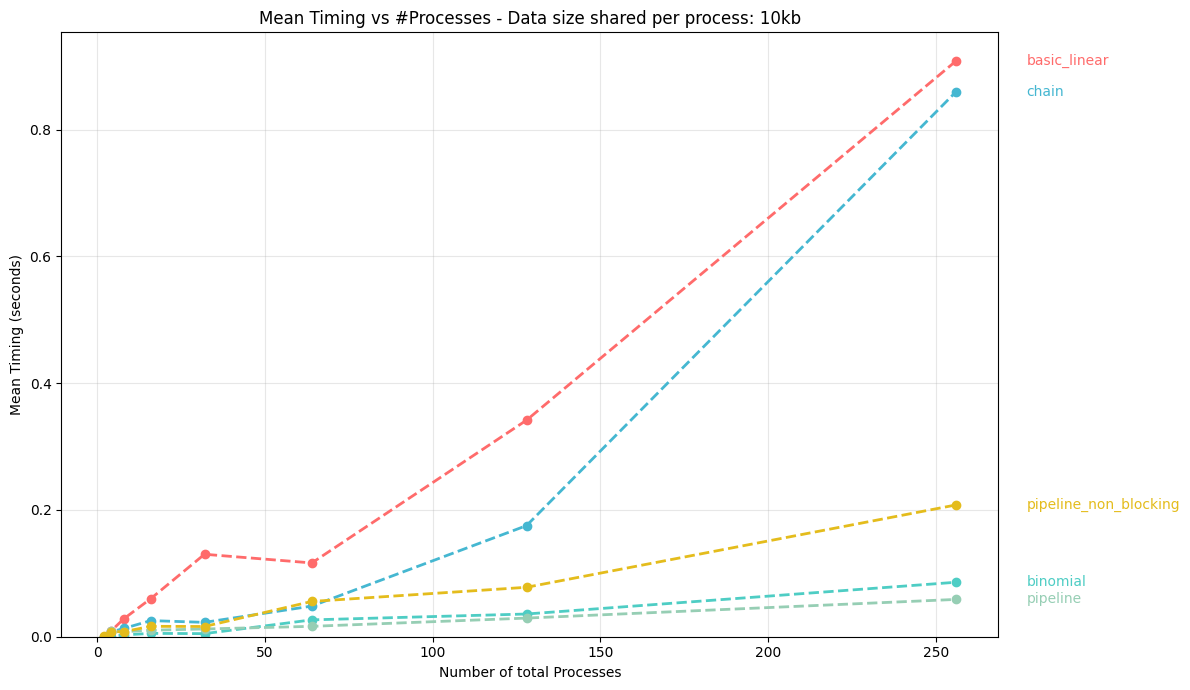


Informazioni sui dati 10kb:
- basic_linear: 8 punti dati
  Processi: 2-256
  Tempi: 0.000106-0.907967 secondi
- binomial: 8 punti dati
  Processi: 2-256
  Tempi: 0.000102-0.085910 secondi
- chain: 8 punti dati
  Processi: 2-256
  Tempi: 0.000102-0.859348 secondi
- pipeline: 8 punti dati
  Processi: 2-256
  Tempi: 0.000161-0.058837 secondi
- pipeline_non_blocking: 8 punti dati
  Processi: 2-256
  Tempi: 0.000783-0.207822 secondi

Grafico per 10kb completato!

=== Creando grafico per 921kb (921600 bytes) ===


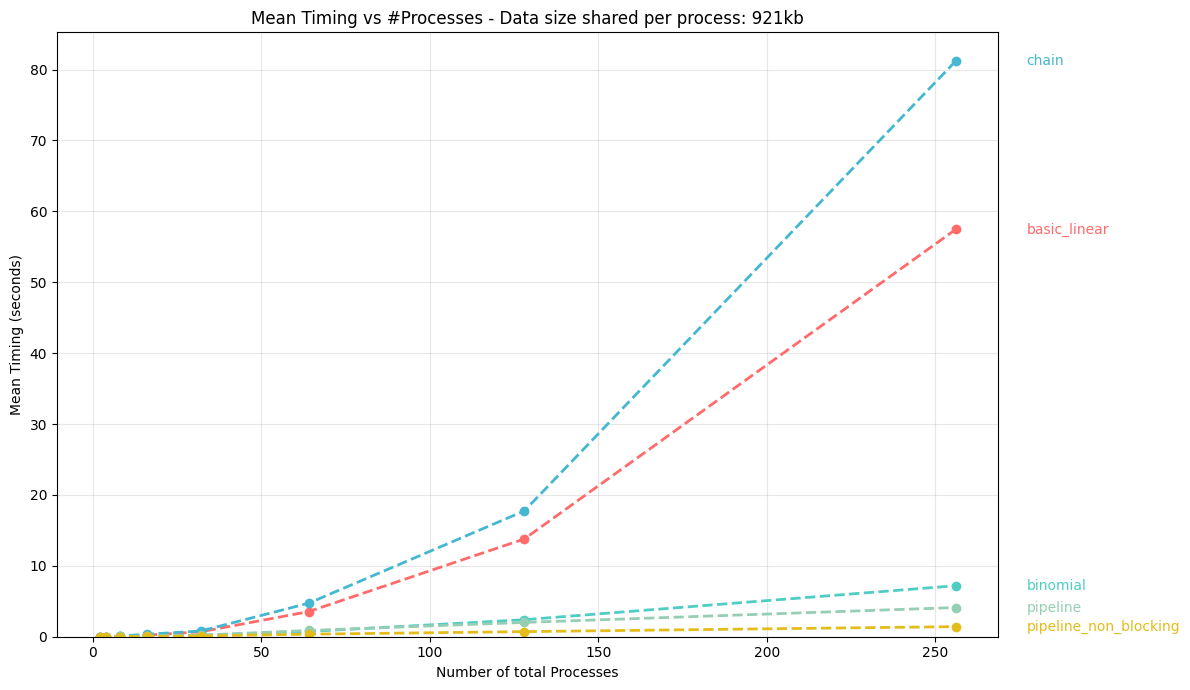


Informazioni sui dati 921kb:
- basic_linear: 8 punti dati
  Processi: 2-256
  Tempi: 0.003616-57.447916 secondi
- binomial: 8 punti dati
  Processi: 2-256
  Tempi: 0.003125-7.191678 secondi
- chain: 8 punti dati
  Processi: 2-256
  Tempi: 0.003885-81.192285 secondi
- pipeline: 8 punti dati
  Processi: 2-256
  Tempi: 0.004595-4.117459 secondi
- pipeline_non_blocking: 8 punti dati
  Processi: 2-256
  Tempi: 0.002911-1.421957 secondi

Grafico per 921kb completato!


In [28]:
# 1. Carica tutti i dataset
base_path = '/home/robertalamberti/HPC-project/ex2/ex_a/bcast'
folder_configs = [
    {'folder': 'csv/weak', 'message_size': 1024},
    {'folder': 'csv2', 'message_size': 10240}, 
    {'folder': 'csv3', 'message_size': 921600}
]

datasets = load_and_merge_all_datasets(base_path, folder_configs)

# 2. Crea tutti i grafici
plot_results = create_all_timing_plots(datasets)